# Raster Embedding Algorithm Demo

This notebook explores various **quantum embedding experiments** using the `dwave_networkx` library. The goal is to embed a 1D ring into different graph topologies (Chimera, Pegasus, and Zephyr) and measure the **time to find embeddings**.

We will:
1. Measure the minimal raster breadth required for embedding.
2. Measure the time required to find **one or multiple embeddings**.
3. Visualize the results using **Seaborn** heatmaps, scatter plots, and line plots.


In [35]:
import dwave_networkx as dnx
from raster_embedding import (
    raster_embedding_search,
)
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd
import json
%matplotlib inline

### Visualize embeddings on hardware graph using the smallest possible tile size:
Th following script visualizes graph embeddings within various D-Wave topologies (chimera, pegasus, and zephyr) by coloring nodes and edges according to their embedding group. It generates and embeds smaller graphs into larger ones, ensuring all nodes are covered without overlaps, and displays each embedding in topology-specific layouts. The visualizations illustrate the structure and connectivity of embedded nodes, showing how smaller graph structures map within each topology.

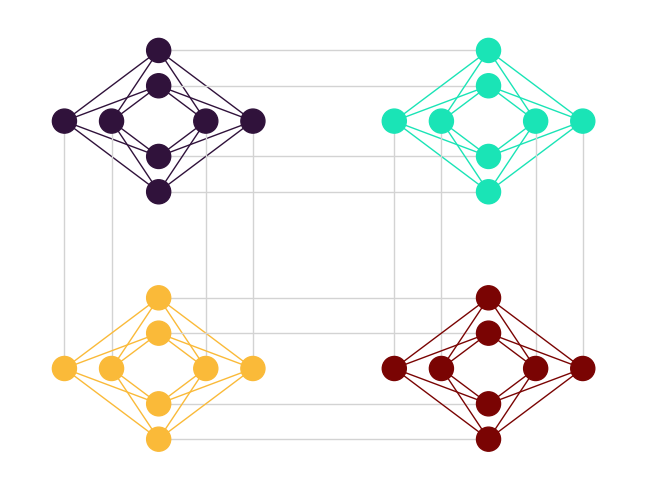

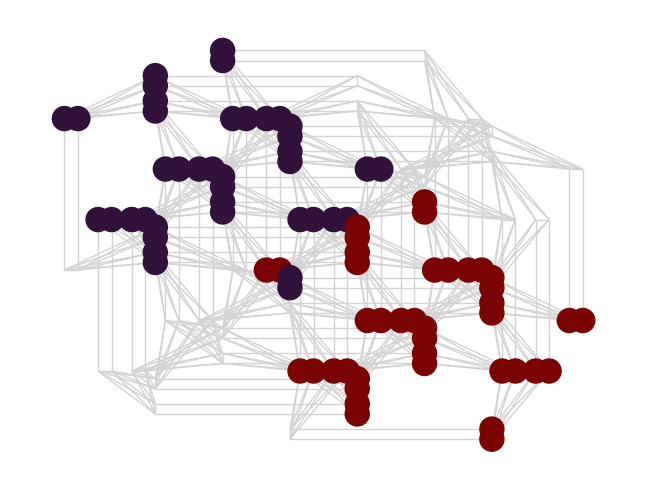

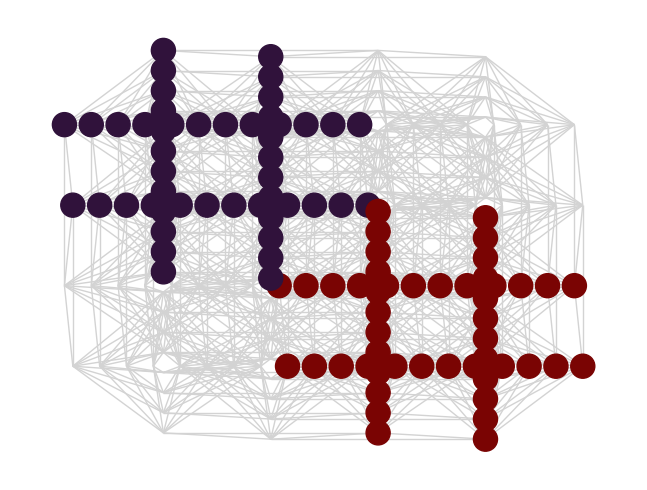

In [17]:
def visualize_embeddings(H, embeddings=None):
    """Visualizes the embeddings using dwave_networkx's layout functions."""
    
    # Initialize figure and axis for each plot
    plt.figure()
    cmap = plt.get_cmap("turbo")
    cmap.set_bad("lightgrey")  # Optional: handles NaNs

    # Create node color mapping
    node_color_dict = {q: float("nan") for q in H.nodes()}
    if embeddings:
        node_color_dict.update(
            {q: idx for idx, emb in enumerate(embeddings, 1) for q in emb.values()}
        )

    # Create edge color mapping
    edge_color_dict = {
        (v1, v2): node_color_dict[v1] if node_color_dict[v1] == node_color_dict[v2] else float("nan")
        for v1, v2 in H.edges()
    }

    # Determine drawing function based on graph topology
    draw_kwargs = {
        'G': H,
        'node_color': [node_color_dict[q] for q in H.nodes()],
        'edge_color': [edge_color_dict[e] for e in H.edges()],
        'node_shape': 'o',
        'with_labels': False,
        'width': 1,
        'cmap': cmap,
        'edge_cmap': cmap,
    }
    
    topology = H.graph.get('family')
    if topology == 'chimera':
        dnx.draw_chimera(**draw_kwargs)
    elif topology == 'pegasus':
        dnx.draw_pegasus(**draw_kwargs)
    elif topology == 'zephyr':
        dnx.draw_zephyr(**draw_kwargs)
    else:
        nx.draw_networkx(**draw_kwargs)

    # Show the plot in the output cell
    plt.show()

# Define the Graph Topologies, Tiles, and Generators
topologies = ['chimera', 'pegasus', 'zephyr']
smallest_tile = {'chimera': 1, 'pegasus': 2, 'zephyr': 1}
generators = {'chimera': dnx.chimera_graph, 'pegasus': dnx.pegasus_graph, 'zephyr': dnx.zephyr_graph}

# A check at minimal scale and visualization
for topology in topologies:
    min_raster_scale = smallest_tile[topology]
    S = generators[topology](min_raster_scale)
    T = generators[topology](min_raster_scale + 1)

    # Perform Embedding Search and Validation
    embs = raster_embedding_search(S, T, raster_breadth=min_raster_scale)
    assert all(set(emb.keys()) == set(S.nodes()) for emb in embs)
    assert all(set(emb.values()).issubset(set(T.nodes())) for emb in embs)
    value_list = [v for emb in embs for v in emb.values()]
    assert len(set(value_list)) == len(value_list)

    # Visualize Embeddings
    visualize_embeddings(T, embeddings=embs)


### Process stored JSON data
processes experimental results stored in a JSON file by transforming and aggregating them for analysis. It first loads data entries related to different tile sizes (L) and topologies, organizes these into a structured DataFrame, and filters for even tile sizes. Next, it handles missing values by replacing "null" entries with NaN and fills remaining missing Time_1 values with 1 for completeness. The script then calculates the mean and standard error of the mean (SEM) of Time_1 for each combination of tile size, topology, and raster breadth, creating an aggregated dataset. This aggregated data is prepared for subsequent visualization or statistical analysis.

In [ ]:
# Load the JSON data from a file
with open('experiment_results/timeout_1_data.json', 'r') as file:
    data = json.load(file)

# Initialize an empty list to store records
records = []

# Iterate over tile sizes (assuming 'L' corresponds to 'tile_size')
for tile_size in data:
    for topology in data[tile_size]:
        raster_breadth = data[tile_size][topology].get('Raster_Breadth', None)
        time_entries = data[tile_size][topology]['Time_1']
        for entry in time_entries:
            record = {
                'L': int(tile_size),
                'Topology': topology,
                'Raster_Breadth': raster_breadth,
                'Run': entry['Run'],
                'm_target': entry['m_target'],
                'Time_1': entry['Time_1'],
            }
            records.append(record)

# Convert the list of records into a DataFrame
df = pd.DataFrame(records)

# Filter for even Ls
df_even = df[df['L'] % 2 == 0]
# Replace 'null' strings with NaN
df_even['Time_1'] = df_even['Time_1'].replace('null', np.nan)

# Convert 'Time_1' to numeric, coercing errors to NaN
df_even['Time_1'] = pd.to_numeric(df_even['Time_1'], errors='coerce')

# Now fill NaN with 1
df_even['Time_1'] = df_even['Time_1'].fillna(1)

# Display the first few rows to verify
print(df_even.head())
print(df_even.dtypes)

df_aggregated = (
    df_even
    .groupby(['L', 'Topology', 'Raster_Breadth'], as_index=False)
    .agg(
        Time_1_mean=('Time_1', 'mean'),
        Time_1_sem=('Time_1', lambda x: np.std(x) / np.sqrt(len(x)))  # SEM
    )
)
print(df_aggregated.head())

### Visualize for all three topologies with confidence interval
visualizes the mean time data across different L values and topologies from the aggregated dataset, with shaded confidence intervals to represent variability. Using Seaborn and Matplotlib, it plots each topology in a distinct color with confidence intervals and marks an upper threshold line for reference. The x- and y-axes are set to logarithmic scales for better readability across a wide data range, and the layout and legend are adjusted for clarity.

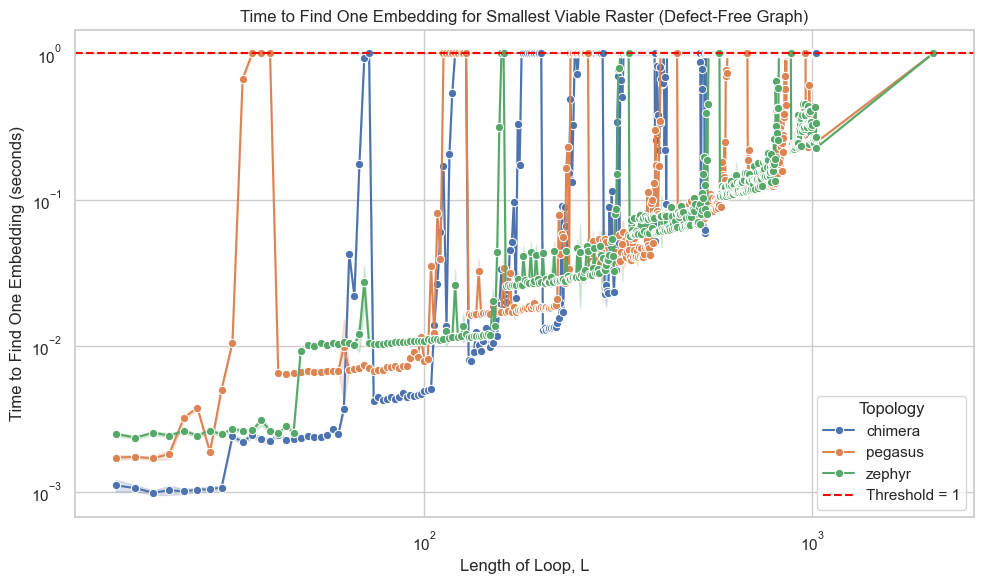

In [11]:
sns.set_theme(style="whitegrid")

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_aggregated,
    x='L',
    y='Time_1_mean',
    hue='Topology',
    marker='o',
    errorbar=None 
)
# Define the confidence interval multiplier for 95% CI
ci_multiplier = 1.96

# Retrieve the unique topologies
topologies = df_aggregated['Topology'].unique()

# Retrieve the color palette used by Seaborn for consistency
palette = sns.color_palette(n_colors=len(topologies))
color_dict = dict(zip(topologies, palette))

# Iterate over each topology to plot confidence intervals
for topology in topologies:
    # Subset the data for the current topology and sort by 'L'
    subset = df_aggregated[df_aggregated['Topology'] == topology].sort_values('L')
    
    # Calculate the confidence interval bounds
    ci_lower = subset['Time_1_mean'] - ci_multiplier * subset['Time_1_sem']
    ci_upper = subset['Time_1_mean'] + ci_multiplier * subset['Time_1_sem']
    
    # Plot the shaded confidence interval
    plt.fill_between(
        subset['L'],
        ci_lower,
        ci_upper,
        color=color_dict[topology],
        alpha=0.2  # Transparency for the shaded region
    )

# Define the upper_threshold
upper_threshold = 1
plt.axhline(
    upper_threshold, 
    color='red', 
    linestyle='--', 
    label=f'Threshold = {upper_threshold}'
)

# Set logarithmic scales
plt.yscale('log')
plt.xscale('log')

# Set labels and title
plt.ylabel('Time to Find One Embedding (seconds)')
plt.xlabel('Length of Loop, L')
plt.title('Time to Find One Embedding for Smallest Viable Raster (Defect-Free Graph)')

# Configure the legend to include only Topology and Threshold
# To exclude the shaded regions from the legend, ensure that fill_between does not add labels
handles, labels = plt.gca().get_legend_handles_labels()
# Remove duplicate labels for Topology
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Topology')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [22]:
print('Chimera:')
print([m**2 * 8 for m in range(1, 16)])
print('Pegasus:')
print([8 +m*(24*(m-1)-8) for m in range(2,16)])
print('Zephyr:')
print([m*(32*m+16) for m in range(1,12)])

Chimera:
[8, 32, 72, 128, 200, 288, 392, 512, 648, 800, 968, 1152, 1352, 1568, 1800]
Pegasus:
[40, 128, 264, 448, 680, 960, 1288, 1664, 2088, 2560, 3080, 3648, 4264, 4928]
Zephyr:
[48, 160, 336, 576, 880, 1248, 1680, 2176, 2736, 3360, 4048]


### Chimera visualization with tile size

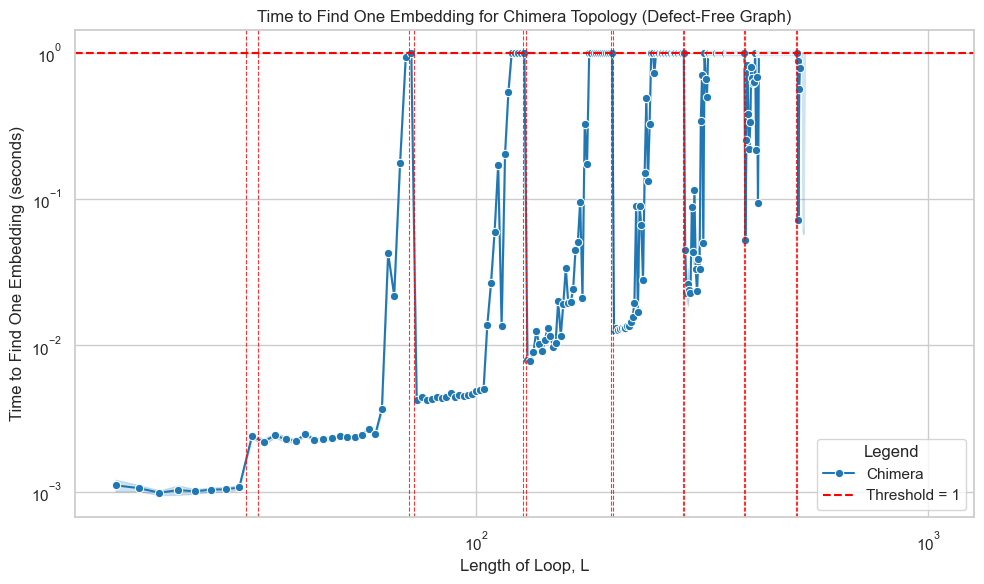

In [40]:
# Create a copy of the original DataFrame
df_chimera = df_aggregated[df_aggregated['Topology'] == 'chimera'].copy()
df_chimera_filtered = df_chimera[(df_chimera['L'] >= 16) & (df_chimera['L'] <= 520)].copy()

chimera_bounds = [31, 33, 71, 73, 127, 129, 199, 201, 287, 289, 391, 393, 511, 513]

# Set the Seaborn theme for consistent styling
sns.set_theme(style="whitegrid")

# Define the confidence interval multiplier for 95% CI
ci_multiplier = 1.96

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot the line for 'chimera' data points in blue
sns.lineplot(
    data=df_chimera_filtered,
    x='L',
    y='Time_1_mean',
    color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
    marker='o',
    label='Chimera'
)

# Calculate the confidence interval bounds
ci_lower = df_chimera['Time_1_mean'] - ci_multiplier * df_chimera['Time_1_sem']
ci_upper = df_chimera['Time_1_mean'] + ci_multiplier * df_chimera['Time_1_sem']

# Plot the shaded confidence interval for 'chimera'
plt.fill_between(
    df_chimera['L'],
    ci_lower,
    ci_upper,
    color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
    alpha=0.2 
)

# Add vertical lines at specified L sizes
for L in chimera_bounds:
    plt.axvline(x=L, color='red', linestyle='--', linewidth=0.8, alpha=0.8)

# Define the upper threshold
upper_threshold = 1
plt.axhline(
    upper_threshold, 
    color='red', 
    linestyle='--', 
    label=f'Threshold = {upper_threshold}'
)

# Set logarithmic scales
plt.yscale('log')
plt.xscale('log')

# Set labels and title
plt.ylabel('Time to Find One Embedding (seconds)')
plt.xlabel('Length of Loop, L')
plt.title('Time to Find One Embedding for Chimera Topology (Defect-Free Graph)')

# Configure the legend to include only necessary entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Legend')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

### Pegasus visualization with tile size 

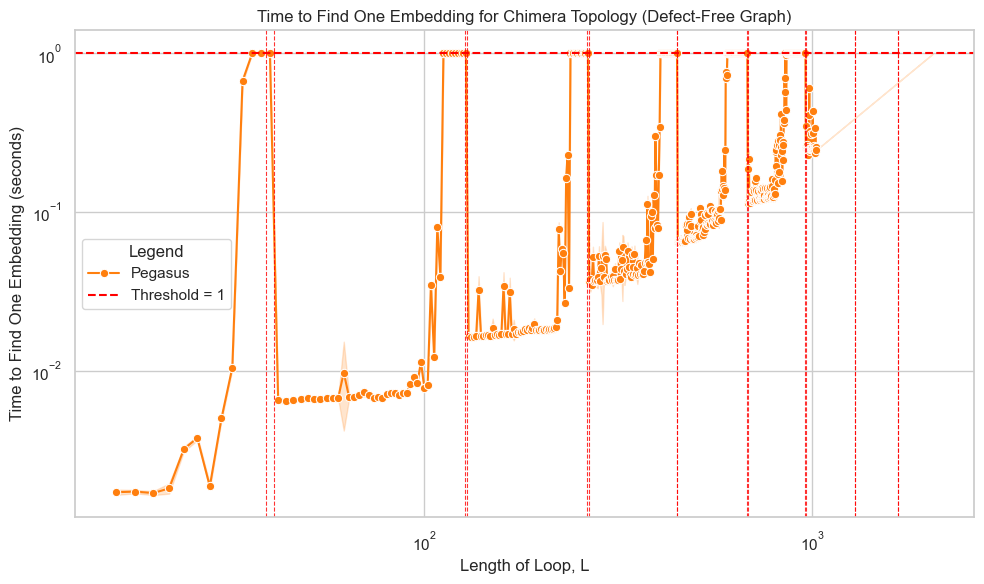

In [44]:
# Create a copy of the original DataFrame
df_pegasus = df_aggregated[df_aggregated['Topology'] == 'pegasus'].copy()
df_pegasus_filtered = df_pegasus[(df_pegasus['L'] >= 16) & (df_pegasus['L'] <= 1700)].copy()

pegasus_bounds = [39, 41, 127, 129, 263, 265, 447, 449, 679, 681, 959, 961, 1287, 1289, 1663, 1665]

# Set the Seaborn theme for consistent styling
sns.set_theme(style="whitegrid")

# Define the confidence interval multiplier for 95% CI
ci_multiplier = 1.96

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot the line for 'pegasus' data points in blue
sns.lineplot(
    data=df_pegasus_filtered,
    x='L',
    y='Time_1_mean',
    color=(1.0, 0.4980392156862745, 0.054901960784313725),
    marker='o',
    label='Pegasus'
)

# Calculate the confidence interval bounds
ci_lower = df_pegasus['Time_1_mean'] - ci_multiplier * df_pegasus['Time_1_sem']
ci_upper = df_pegasus['Time_1_mean'] + ci_multiplier * df_pegasus['Time_1_sem']

# Plot the shaded confidence interval for 'pegasus'
plt.fill_between(
    df_pegasus['L'],
    ci_lower,
    ci_upper,
    color=(1.0, 0.4980392156862745, 0.054901960784313725),
    alpha=0.2 
)

# Add vertical lines at specified L sizes
for L in pegasus_bounds:
    plt.axvline(x=L, color='red', linestyle='--', linewidth=0.8, alpha=0.8)

# Define the upper threshold
upper_threshold = 1
plt.axhline(
    upper_threshold, 
    color='red', 
    linestyle='--', 
    label=f'Threshold = {upper_threshold}'
)

# Set logarithmic scales
plt.yscale('log')
plt.xscale('log')

# Set labels and title
plt.ylabel('Time to Find One Embedding (seconds)')
plt.xlabel('Length of Loop, L')
plt.title('Time to Find One Embedding for Chimera Topology (Defect-Free Graph)')

# Configure the legend to include only necessary entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Legend')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

### Zephyr visualization with tile size

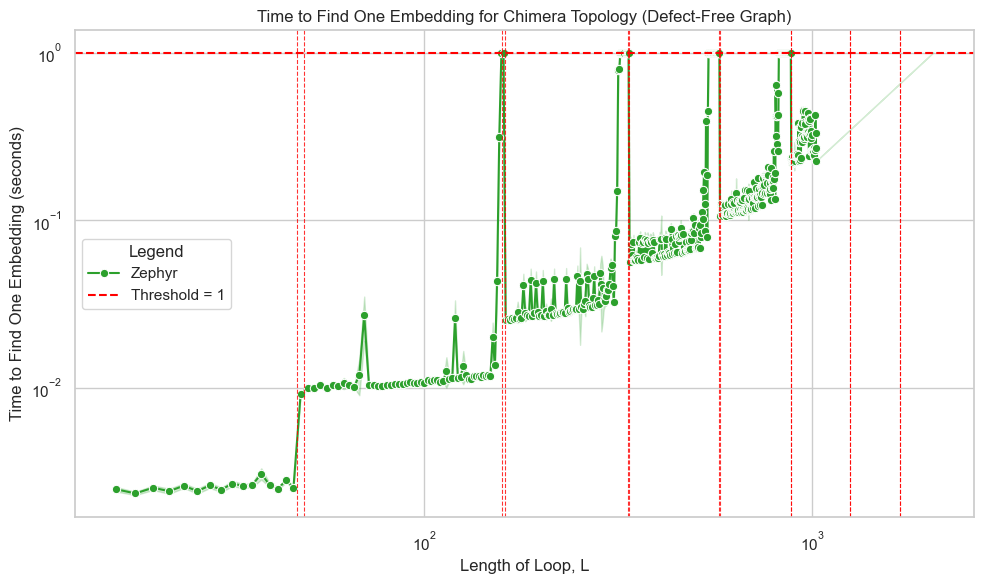

In [45]:
# Create a copy of the original DataFrame
df_zephyr= df_aggregated[df_aggregated['Topology'] == 'zephyr'].copy()
df_zephyr_filtered = df_zephyr[(df_zephyr['L'] >= 16) & (df_zephyr['L'] <= 1700)].copy()

zephyr_bounds = [47, 49, 159, 161, 335, 337, 575, 577, 879, 881, 1247, 1249, 1679, 1681]

# Set the Seaborn theme for consistent styling
sns.set_theme(style="whitegrid")

# Define the confidence interval multiplier for 95% CI
ci_multiplier = 1.96

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot the line for 'zephyr' data points in blue
sns.lineplot(
    data=df_zephyr_filtered,
    x='L',
    y='Time_1_mean',
    color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
    marker='o',
    label='Zephyr'
)

# Calculate the confidence interval bounds
ci_lower = df_zephyr['Time_1_mean'] - ci_multiplier * df_zephyr['Time_1_sem']
ci_upper = df_zephyr['Time_1_mean'] + ci_multiplier * df_zephyr['Time_1_sem']

# Plot the shaded confidence interval for 'zephyr'
plt.fill_between(
    df_zephyr['L'],
    ci_lower,
    ci_upper,
    color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
    alpha=0.2 
)

# Add vertical lines at specified L sizes
for L in zephyr_bounds:
    plt.axvline(x=L, color='red', linestyle='--', linewidth=0.8, alpha=0.8)

# Define the upper threshold
upper_threshold = 1
plt.axhline(
    upper_threshold, 
    color='red', 
    linestyle='--', 
    label=f'Threshold = {upper_threshold}'
)

# Set logarithmic scales
plt.yscale('log')
plt.xscale('log')

# Set labels and title
plt.ylabel('Time to Find One Embedding (seconds)')
plt.xlabel('Length of Loop, L')
plt.title('Time to Find One Embedding for Chimera Topology (Defect-Free Graph)')

# Configure the legend to include only necessary entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Legend')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()